# São Tomé

In this application we will set to two fixed traps and import an externally-generated
migration matrix. 

We will begin by loading all the required libraries and packages:

In [66]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
import MGSurvE as srv
import cartopy.crs as ccrs

## Landscape

We will now setup some of the experiment's constants. In this case we will setup the experiment to 7 traps (`TRPS`) by default with the option to set two traps as fixed (`FXD_TRPS`) as `True`. These fixed traps will be located in two small landmasses at the north and south of the main São Tomé landscape. The experiment id `ID` is just a label for the output files, with the run id `RID` being used for iterations of the stochastic optimization process; and the `IX_SPLIT` used to separate to separate sites in São Tomé from the ones in the island of Príncipe. Finally, we will create a folder to export our results into.

In [80]:
(TRPS_NUM, FXD_TRPS) = (7, True)
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('STP', 0)
IX_SPLIT = 27
# Output folder ---------------------------------------------------------------
OUT_PTH = './sims_out/'
srv.makeFolder(OUT_PTH)

We need to read our points coordinates. These positions are stored in a CSV file as *longitude/latitude* format, so we will load them into a pandas dataframe and set them to the same point-type (`t`):

In [78]:
sites = pd.read_csv(path.join('./GEO', 'STP_LatLonN.csv'))
sites['t'] = [0]*sites.shape[0]

Our original CSV file contains the information for both São Tomé and Príncipe, but in this example we will be focusing on the main São Tomé land, so we will split the dataframe to get the positions we are interested on (`SAO_TOME_LL`). At the same time, we will get the landscape bounding box (`SAO_bbox`), center (`SAO_cntr`), and the ID of the nodes where we want our fixed traps to be in (`SAO_FIXED`):

In [100]:
# Get longitude-latitudes for main island -------------------------------------
SAO_TOME_LL = sites.iloc[IX_SPLIT:]
# Get bounding box ------------------------------------------------------------
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
# Get centroid ----------------------------------------------------------------
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))
# Get sites IDs for fixed traps -----------------------------------------------
SAO_FIXED = [51-IX_SPLIT, 239-IX_SPLIT]
FXD_NUM = len(SAO_FIXED)

We now import the migration matrix and split it to get the São Tomé subset of transitions (`SAO_TOME_MIG`):

In [87]:
migration = np.genfromtxt(
    path.join('./GEO', 'STP_MigrationN.csv'), delimiter=','
)
# Spliting up Sao Tome and making sure rows are normalized --------------------
msplit = migration[IX_SPLIT:,IX_SPLIT:]
SAO_TOME_MIG = normalize(msplit, axis=1, norm='l1')

We now setup the traps. In this case we will set all the traps to the same type `0`. Generally speaking, the initial position in terms of longitud and latitude is not important in this case as we will be doing discrete optimization, but the current version of MGSurvE still needs some positions vector to be provided (will likely get deprecated in future releases). Something that is important, however, is that we setup our fixed traps in the right node id for them to be located in the small masses of land at the north and south of the island (`SAO_FIXED`), so we setup a vector of a number of traps that can be placed at whichever node we want (`0`, in this case), and two traps that are located in specific nodes (`SAO_FIXED` which are `[24, 212]`).

In [91]:
(initTyp, initFxd) = ([0]*TRPS_NUM, [0]*TRPS_NUM)
if FXD_TRPS:
    initFxd = ([0]*(TRPS_NUM-FXD_NUM) + [1]*FXD_NUM)
# Initialize the position of traps (not strictly needed) ----------------------
(initLon, initLat) = ([[SAO_cntr[0]]*TRPS_NUM, [SAO_cntr[1]]*TRPS_NUM])
# Initialize traps to nodes IDs -----------------------------------------------
sid = [0]*(TRPS_NUM-FXD_NUM) + SAO_FIXED 

With this in place, we can setup our trap kernel and our traps dataframe:

In [93]:
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}
# Initialize traps ------------------------------------------------------------
traps = pd.DataFrame({
    'sid': sid, 'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})

We can now initialize our landscape with the info we gathered from our previous steps:

In [101]:
lnd = srv.Landscape(
    SAO_TOME_LL, migrationMatrix=SAO_TOME_MIG,
    traps=traps, trapsKernels=tKer, 
    landLimits=SAO_LIMITS
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

And let's plot our landscape now!

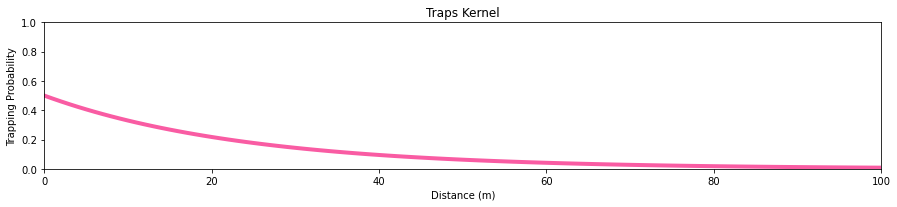

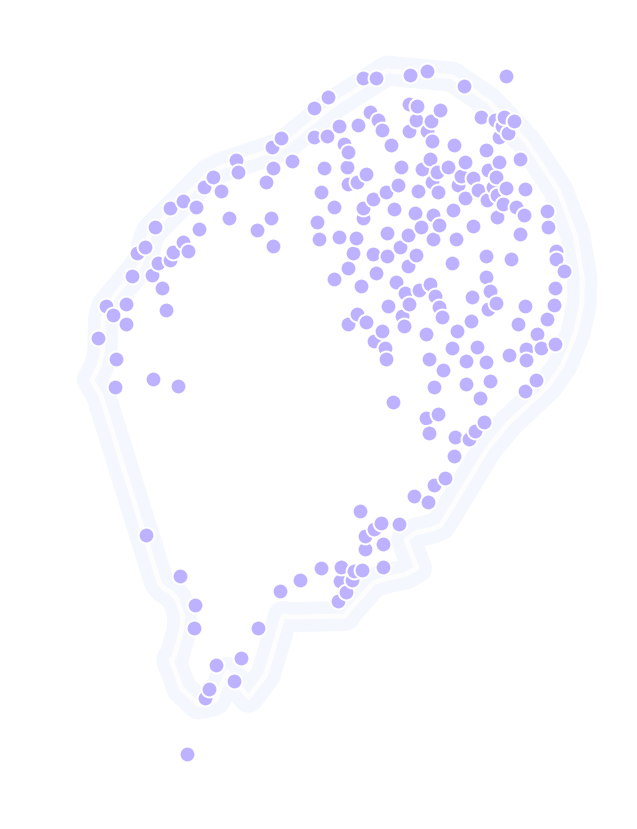

In [103]:
# Plot Traps Kernels ----------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
(fig, ax) = srv.plotTrapsKernels(fig, ax, lnd, distRange=(0, 100), aspect=.175)
ax.set_title("Traps Kernel")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Trapping Probability")
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_KER.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)
# Plot Landscape --------------------------------------------------------------
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{:02d}_CLN.png'.format(ID, TRPS_NUM)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

## Optimization

In [84]:
(GENS, GA_SUMSTAT, VERBOSE) = (10, np.mean, False)
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
VERBOSE = True
# Reducing the bbox for init sampling -----------------------------------------
redFract = .25
reduction = [(i[1]-i[0])/2*redFract for i in bbox]
bboxRed = [(i[0]+r, i[1]-r) for (i, r) in zip(bbox,reduction)]

In [85]:
outer = GA_SUMSTAT
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': outer}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

/home/hector/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/hector/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg    	max    	std    	best	traps                           
0  	105   	1771.5	2412.98	4532.35	420.922	88  	[149, 88, 36, 154, 124, 24, 212]
1  	65    	1662.14	2260.59	3712.33	325.908	35  	[188, 182, 88, 19, 158, 24, 212]
2  	59    	1662.14	2167.31	3336.33	271.128	92  	[188, 182, 88, 19, 158, 24, 212]
3  	65    	1662.14	2119.24	3484.72	332.665	6   	[188, 182, 88, 19, 158, 24, 212]
4  	58    	1662.14	2034.81	3398.28	299.991	5   	[188, 182, 88, 19, 158, 24, 212]
5  	52    	1633.08	1996.16	3952.47	356.638	67  	[185, 88, 19, 154, 124, 24, 212]
6  	56    	1582.01	1977.71	3697.45	379.384	89  	[208, 180, 88, 19, 124, 24, 212]
7  	56    	1582.01	1882.91	2989.4 	298.413	4   	[208, 180, 88, 19, 124, 24, 212]
8  	63    	1619.89	1903.93	4080.39	364.061	34  	[17, 154, 148, 105, 174, 24, 212]
9  	55    	1631.56	1899.85	3038.84	330.083	4   	[188, 182, 88, 19, 183, 24, 212] 
10 	65    	1589.29	1894.99	2664.99	293.251	48  	[191, 180, 88, 19, 158, 24, 212] 


## Analysis

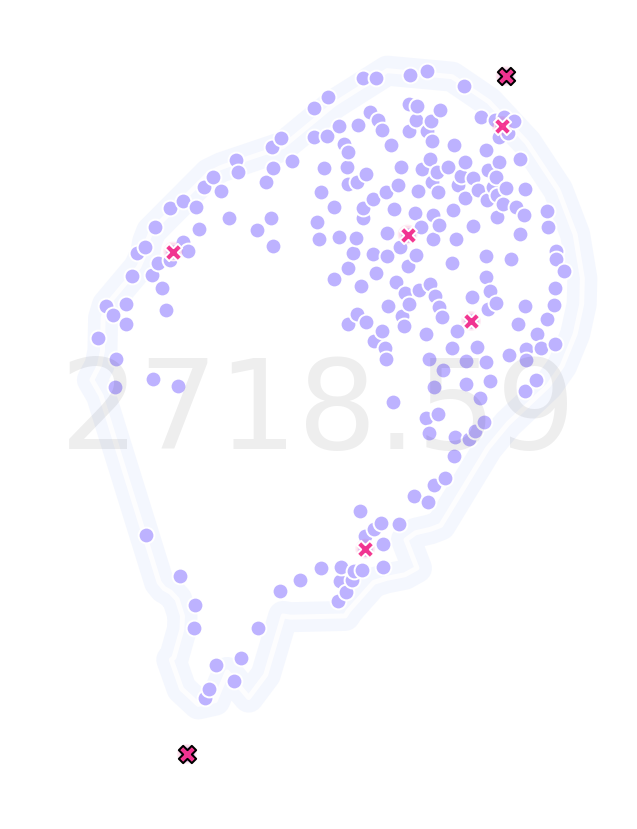

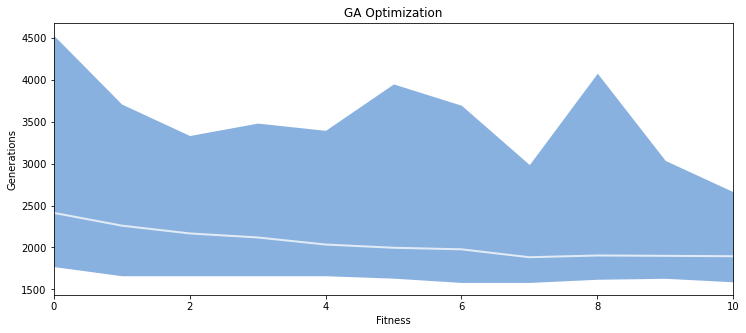

In [86]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    latlon=True, proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
srv.plotFitness(fig, ax, min(log['min']), fmt='{:.2f}')
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)
# GA --------------------------------------------------------------------------
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
ax.set_title("GA Optimization")
ax.set_xlabel("Fitness")
ax.set_ylabel("Generations")
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=1/2.5
)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)